<a href="https://colab.research.google.com/github/Stone-bridge-NLP/BERT/blob/main/GenreClassification_BERT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting environment

In [1]:
# required packages to use BERT via hub models
%%bash
pip install tqdm boto3 requests regex sentencepiece sacremoses

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
# additional packages required (to avoid error, not mentioned in the tutorial)
!pip install huggingface_hub
!pip install tokenizers

     |████████████████████████████████| 59 kB 4.7 MB/s 
     |████████████████████████████████| 3.3 MB 10.0 MB/s 


In [3]:
!git clone https://github.com/Stone-bridge-NLP/BERT.git
%cd /content/BERT

Cloning into 'BERT'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 34 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.
/content/BERT


In [4]:
# download shared dataset to local disk
# [차도인] [오후 9:37] https://drive.google.com/file/d/168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-/view?usp=sharing
!gdown --id 168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-
FILENAME = 'preprocessed_train_data.csv'

Downloading...
From: https://drive.google.com/uc?id=168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-
To: /content/BERT/preprocessed_train_data.csv
100% 252M/252M [00:01<00:00, 238MB/s]


# Train model

In [5]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import utils

In [6]:
train_dataset = pd.read_csv('./'+FILENAME)
print(train_dataset)

        Unnamed: 0  Genre                                             Lyrics
0                0   Rock  it starts with pain followed by hate fueled by...
1                1   Rock  freedom alone again again alone patiently wait...
2                2   Rock  biting the hand that feeds you lying to the vo...
3                3   Rock  you say you know just who i am but you can t i...
4                4   Rock  my heart is beating faster can t control these...
...            ...    ...                                                ...
209268      249943    R&B  i m the best friend he s got i d give him the ...
209269      249944    Pop  bad boys blue i totally miss you i did you wro...
209270      249945    Pop  forgive me for the things that i never said to...
209271      249946  Indie  the day they found a cure for aids the day the...
209272      249947    Pop  fourth of july has come it s custom that we go...

[209273 rows x 3 columns]


In [7]:
# Balance sampling of the DATA.
# problem here is that some genre is oversampled too much(copied 11 times)
# another problem is that this samping happens during the runtime,
# so train set and validation set is mixed up every new runtime
# ==========SOLUTION========
# First split the whole train data into 8:2 train and validation set
# to make sure they do not get mixed up
# Reduce the dataset to desired size afterwards
# 
# To prevent overcopying, start the learning with equally distributed small dataset
# Rather than overcopying, use the weighted loss
# while gradually breaking the balance by less undersampling

Genre = ['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
train_dataset = train_dataset[['Genre', 'Lyrics']]
train_dataset = train_dataset.drop(train_dataset[train_dataset['Genre']=='en'].index)


print('====== validation set =======')
val_d = []
for genre in Genre:
  td = train_dataset[train_dataset['Genre'] == genre]
  val_d.append(td.sample(frac=0.2,random_state=31415))
  print(f'{genre}\tsample ratio\t {len(td)}:{len(val_d[-1])}')  
val_dataset = pd.concat(val_d)

train_dataset = train_dataset.drop(val_dataset.index)

train_dataset = train_dataset.reset_index().drop(columns='index')
val_dataset = val_dataset.reset_index().drop(columns='index')
    

====== validation set =======
Electronic	sample ratio	 1831:366
Country	sample ratio	 1594:319
R&B	sample ratio	 2482:496
Jazz	sample ratio	 7026:1405
Indie	sample ratio	 6509:1302
Pop	sample ratio	 69934:13987
Folk	sample ratio	 7333:1467
Metal	sample ratio	 17283:3457
Hip-Hop	sample ratio	 2068:414
Rock	sample ratio	 93213:18643


In [8]:
class LyricsAndGenreDataset(Dataset):
  def __init__(self, dataframe, tokenizer, num_sentence):
    self.df = dataframe
    self.tk = tokenizer
    self.num_sentence = num_sentence
    self.genre_name2id = {
        'Electronic':0, 
        'Country':1, 
        'R&B':2, 
        'Jazz':3, 
        'Indie':4, 
        'Pop':5, 
        'Folk':6, 
        'Metal':7, 
        'Hip-Hop':8, 
        'Rock':9}

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    genre = self.genre_name2id[self.df['Genre'][idx]]
    lyric = [self.df['Lyrics'][idx]]

    with torch.no_grad():
      indexed_tokens = self.tk.batch_encode_plus(
            lyric, add_special_tokens=True, padding= 'max_length', 
            max_length=2**9*self.num_sentence, truncation=True)
      
      tk_tensor = torch.tensor(indexed_tokens['input_ids']).view(-1,2**9)
      sg_tensor = torch.tensor(indexed_tokens['token_type_ids']).view(-1,2**9)
      at_tensor = torch.tensor(indexed_tokens['attention_mask']).view(-1,2**9)

    return genre, tk_tensor, sg_tensor, at_tensor



In [9]:
class TextCNN(nn.Module):
  def __init__(self, n_class):
    super(TextCNN, self).__init__()

    self.layer_conv = nn.Sequential(
        nn.Conv2d(1,64,(2,5),(2,1)),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(64),
        nn.Conv2d(64,256,(2,5),(2,2)),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(256),
        nn.Conv2d(256,128,(2,5),(2,2)),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(128),
        nn.Conv2d(128,64,(2,5),(2,1)),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(64),
        nn.Conv2d(64,32,(2,5),(2,1)),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(32),
        nn.Conv2d(32,32,(2,5),(2,1)),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(32),
        nn.Conv2d(32,16,(2,5),(2,1)),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(16),
        nn.Conv2d(16,4,(2,5),(2,1)),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(4),
        nn.Conv2d(4,1,(2,5),(2,1)),
        nn.LeakyReLU(0.2, True)
    )

    self.linlayer = nn.Sequential(
        nn.Linear(164,100),
        nn.ReLU(True),
        nn.Linear(100,50),
        nn.ReLU(True),
        nn.Linear(50,10),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    
    x = x.view(-1,1,x.shape[1],x.shape[2])
    out = self.layer_conv(x)
    out = out.view(-1,164)
    out = self.linlayer(out)
    
    return out

In [10]:
#### hyperparameters ####
epoch = 5
lr = 0.001
batch_size = 32
num_sentences = 1
save_epoch = 1
save_path = 'checkpoint_cnn.pth'
epoch_start = 0
dataset_fraction = 0.06

# fixed
v_dim = 768
n_genre = 10
genre_id2name = ['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
genre_name2id = {'Electronic':0, 'Country':1, 'R&B':2, 'Jazz':3, 'Indie':4, 'Pop':5, 'Folk':6, 'Metal':7, 'Hip-Hop':8, 'Rock':9}
device = torch.device('cuda') if (torch.cuda.is_available())else torch.device('cpu')

In [11]:
# load pretrained BERT tokenizer and bare BERT model
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')
bert_embedding = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased').to(device)

# undersample the dataset to desired size
reduced_train_dset,tr_loss_coef = utils.dfRandomSample(train_dataset,dataset_fraction)
print(tr_loss_coef)
reduced_val_dset, vl_loss_coef = utils.dfRandomSample(val_dataset,dataset_fraction)
print(vl_loss_coef)

# declare torch.utils.data.Dataset
train_set = LyricsAndGenreDataset(reduced_train_dset,tokenizer,num_sentences)
val_set = LyricsAndGenreDataset(reduced_val_dset,tokenizer,num_sentences)

# train and validation data loader
train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)
val_loader = DataLoader(val_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)

cnn_classifier = TextCNN(n_genre).to(device)

# load model if possible
try:
  cp = torch.load(save_path)
  epoch_start= cp['current_epoch']+1
  cnn_classifier.load_state_dict(cp['model'])
  print(f'\nsavefile from {save_path} loaded')
except FileNotFoundError:
  print('\nno savefile to load')

print(cnn_classifier)
print(sum(p.numel() for p in cnn_classifier.parameters() if p.requires_grad))
loss_func = nn.CrossEntropyLoss(reduction='none')
params = list(cnn_classifier.parameters())
optimizer = optim.Adam(params, lr=lr)

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/master.zip" to /root/.cache/torch/hub/master.zip


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Country	 sample ratio	 1275:1004
Electronic	 sample ratio	 1465:1004
Hip-Hop	 sample ratio	 1654:1004
R&B	 sample ratio	 1986:1004
Indie	 sample ratio	 5207:1004
Jazz	 sample ratio	 5621:1005
Folk	 sample ratio	 5866:1005
Metal	 sample ratio	 13826:1005
Pop	 sample ratio	 55947:1005
Rock	 sample ratio	 74570:1005
Total size : 10045

{'Metal': 0.999502487562189, 'Jazz': 0.999502487562189, 'Folk': 0.999502487562189, 'Pop': 0.999502487562189, 'Rock': 0.999502487562189, 'R&B': 1.0004980079681274, 'Electronic': 1.0004980079681274, 'Indie': 1.0004980079681274, 'Country': 1.0004980079681274, 'Hip-Hop': 1.0004980079681274}
Country	 sample ratio	 319:251
Electronic	 sample ratio	 366:251
Hip-Hop	 sample ratio	 414:251
R&B	 sample ratio	 496:251
Indie	 sample ratio	 1302:251
Jazz	 sample ratio	 1405:251
Folk	 sample ratio	 1467:251
Metal	 sample ratio	 3457:251
Pop	 sample ratio	 13987:251
Rock	 sample ratio	 18643:252
Total size : 2511

{'Rock': 0.9964285714285713, 'Jazz': 1.000398406374502, 'F

In [12]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []


for e in range(epoch_start, epoch, 1):
  for b,batch in enumerate(train_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device)
    sg_batch = batch[2].to(device)
    at_batch = batch[3].to(device)

    loss_coef = torch.tensor(
        [tr_loss_coef[genre_id2name[i]] for i in batch[0]]).to(device)

    with torch.no_grad():
      embedding = bert_embedding(
          tk_batch.view(-1,2**9), 
          token_type_ids= sg_batch.view(-1,2**9),
          attention_mask=at_batch.view(-1,2**9))

    embedded_tokens = embedding[0].detach().view(batch_size,2**9*num_sentences,-1)

    output = cnn_classifier.forward(embedded_tokens)

    optimizer.zero_grad()
    loss = torch.mean(loss_coef*loss_func(output, label_batch))
    loss.backward()
    optimizer.step()
    
    if b%4 == 0:
      train_loss_list.append(float(loss.detach().cpu().data))
      pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
      acc = np.mean(pred == label_batch.detach().cpu().numpy().flatten())
      train_acc_list.append(float(acc))

      print(f'\rTRAIN: epoch [{e}/{epoch}] batch [{b}/{len(train_loader)}]\
       loss {train_loss_list[-1]}\t acc {train_acc_list[-1]}', end='\t')

  for b,batch in enumerate(val_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device)
    sg_batch = batch[2].to(device)
    at_batch = batch[3].to(device)

    loss_coef = torch.tensor(
        [vl_loss_coef[genre_id2name[i]] for i in batch[0]]).to(device)

    with torch.no_grad():
      embedding = bert_embedding(
          tk_batch.view(-1,2**9), 
          token_type_ids= sg_batch.view(-1,2**9),
          attention_mask=at_batch.view(-1,2**9))

      embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)

      output = cnn_classifier.forward(embedded_tokens)

      optimizer.zero_grad()
      loss = torch.mean(loss_coef*loss_func(output, label_batch))
    

    val_loss_list.append(float(loss.detach().cpu().data))
    pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
    acc = np.mean(pred == label_batch.detach().cpu().numpy().flatten())
    val_acc_list.append(float(acc))

    print(f'\rVAL: [{e}/{epoch}] batch [{b}/{len(val_loader)}]\
       loss {val_loss_list[-1]}\t acc {val_acc_list[-1]}', end='\t')

  if e%save_epoch == 0:
    utils.save_checkpoint(e,cnn_classifier,save_path)

VAL: [4/5] batch [77/78]       loss 2.050590543595329	 acc 0.40625	

no savefile


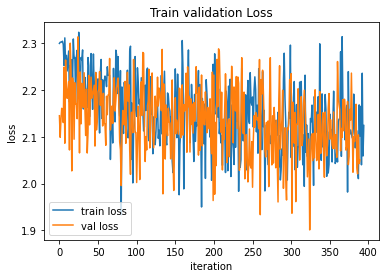

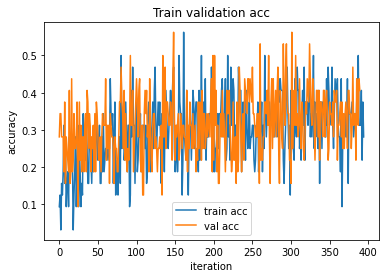

In [13]:
import matplotlib.pyplot as plt

try:
  tll = np.load('train_loss_list.npy')
  vll = np.load('val_loss_list.npy')
  tal = np.load('train_acc_list.npy')
  val = np.load('val_acc_list.npy')

  tll = tll.tolist() + train_loss_list
  vll = vll.tolist() + val_loss_list
  tal = tal.tolist() + train_acc_list
  val = val.tolist() + val_acc_list
except FileNotFoundError:
  print('no savefile')
  tll = train_loss_list
  vll = val_loss_list
  tal = train_acc_list
  val = val_acc_list



plt.title('Train validation Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(tll, label='train loss')
plt.plot(vll, label='val loss')
plt.legend()
plt.show()


plt.title('Train validation acc')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.plot(tal, label='train acc')
plt.plot(val, label='val acc')
plt.legend()
plt.show()

In [14]:
np.save('train_loss_list.npy',tll)
np.save('val_loss_list.npy',vll)
np.save('train_acc_list.npy',tal)
np.save('val_acc_list.npy',val)

In [15]:
# [차도인] [오후 9:37] https://drive.google.com/file/d/168qGvi5w4Wwgu5QTpPoLkZzoJNAgyc6b/view?usp=sharing
!gdown --id 168qGvi5w4Wwgu5QTpPoLkZzoJNAgyc6b
TESTFILENAME = 'preprocessed_test_data.csv'

Downloading...
From: https://drive.google.com/uc?id=168qGvi5w4Wwgu5QTpPoLkZzoJNAgyc6b
To: /content/BERT/preprocessed_test_data.csv
100% 9.63M/9.63M [00:00<00:00, 81.7MB/s]


In [16]:
batch_size = 128

test_dataset = pd.read_csv('./'+TESTFILENAME)
print(test_dataset['Genre'].value_counts())
print(len(test_dataset))

# declare torch.utils.data.Dataset
test_set = LyricsAndGenreDataset(test_dataset,tokenizer,num_sentences)

# test data loader
test_loader = DataLoader(test_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)



Rock          1410
Pop           1110
Hip-Hop        960
Metal          810
Country        810
Electronic     659
Jazz           659
Indie          510
R&B            509
Folk           495
Name: Genre, dtype: int64
7932


In [18]:
cnn_classifier.eval()
c_mat = np.zeros((10,4)) # confusion matrix. TP, FP, FN, TN
f1 = []
with torch.no_grad():
  for b, batch in enumerate(test_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device)
    sg_batch = batch[2].to(device)
    at_batch = batch[3].to(device)

    embedding = bert_embedding(
        tk_batch.view(-1,2**9), 
        token_type_ids= sg_batch.view(-1,2**9),
        attention_mask=at_batch.view(-1,2**9))

    embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)

    output = cnn_classifier.forward(embedded_tokens)

    ###
    o = output.detach().cpu().numpy()
    # print(np.argmax(o,axis=1))
    
    pred = torch.argmax(output,axis=1)

    acc = float(torch.sum(pred == label_batch))/batch_size
    print(f'\rbatch [{b}/{len(val_loader)}] acc: {acc}', end='\t')

    for i in range(10):
      c_mat[i,0] += int(torch.sum((pred == i)*(label_batch == i)))
      c_mat[i,1] += int(torch.sum((pred == i)*(label_batch != i)))
      c_mat[i,2] += int(torch.sum((pred != i)*(label_batch == i)))
      c_mat[i,3] += int(torch.sum((pred != i)*(label_batch != i)))


print()

precision = [c[0]/(c[0]+c[1]) if c[0] != 0 else 0 for c in c_mat]
recall = [c[0]/(c[0]+c[2]) if c[0] != 0 else 0 for c in c_mat]

f1 = [2*p*r/(p+r) if p*r != 0 else 0 for p, r in zip(precision,recall)]

print('f1 score each class')
print(f1)
print('overall f1 score')
print(np.mean(f1))


batch [60/78] acc: 0.2734375	
f1 score each class
[0.23499142367066894, 0.3838978890525282, 0.2049518569463549, 0.2817109144542773, 0.1797752808988764, 0.009009009009009007, 0.25867507886435337, 0.5701509223029625, 0.7122557726465364, 0.057441253263707574]
overall f1 score
0.28928594011092745


In [ ]:
print([genre_id2name[i] for i in range(10)])
print(c_mat)


In [ ]:
test_dataset = pd.read_csv('./'+TESTFILENAME)

print(test_dataset['Genre'].value_counts())
P = [n/len(test_dataset) for n in test_dataset['Genre'].value_counts()]
print(P)
f1_score = {n:2*p*0.5/(0.5+p) for n, p in zip(test_dataset['Genre'].value_counts().index, P)}
print(f1_score)
print(sum(f1_score.values())/10)
# print(np.mean(f1_score.values()))